In [27]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings(action = 'ignore')

In [23]:
#CHapter02  140pg 참고
#Titanic 데이터 전처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N',inplace = True)
    df['Embarked'].fillna('N',inplace = True)
    df['Fare'].fillna(0,inplace = True)
    return df

#불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'], axis= 1, inplace = True)
    return df

#레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features=['Cabin','Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

#모든 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df
        

## MNIST데이터를 변환하여 불균형하게 만든 후 정확도 지표 적용해보기

In [2]:
class MyFakeClassifier(BaseEstimator):
    def fit(self, X,y):
        pass
    
    #입력값으로 들어오는 X데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self, X):
        return np.zeros((len(X),1), dtype = bool)

In [4]:
digits = load_digits()#데이터 로딩
#digits번호가 7번이면 True고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환
y=(digits.target==7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y,random_state = 11)

In [5]:
#불균형한 레이블 데이터 분포도 확인
print("레이블 테스트 세트 크기:",y_test.shape)
print("테스트 세트 레이블 0과 1의 분포도")
print(pd.Series(y_test).value_counts())

레이블 테스트 세트 크기: (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64


In [12]:
#Dummy Clasifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train,y_train)
fakepred=fakeclf.predict(X_test)
print("모든 예측을 0으로 하였을 때 정확도: ", accuracy_score(y_test,fakepred))

모든 예측을 0으로 하였을 때 정확도:  0.9


-----------
-> 모두 0(False)으로 반환해도 데이터의 불균형 때문에 정확도가 0.9씩이나 나온다.

## 오차행렬

In [11]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]], dtype=int64)

In [7]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix

In [13]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print("오차 행렬")
    print(confusion)
    print("정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}".format(accuracy, precision, recall))

In [24]:
from sklearn.linear_model import LogisticRegression
#원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df=pd.read_csv('./Titanic/train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived',axis=1)
X_titanic_df = transform_features(X_titanic_df)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df,test_size=0.3, random_state = 12)

In [33]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train,y_train)
pred = lr_clf.predict(X_test)#default threshold = 0.5
get_clf_eval(y_test,pred)

오차 행렬
[[137  24]
 [ 37  70]]
정확도: 0.7724, 정밀도: 0.7447, 재현율: 0.6542


In [34]:
pred.shape

(268,)

In [36]:
pred.reshape(-1,1).shape#1차원은 그대로, 2차원은 1

(268, 1)

In [31]:
pred_proba=lr_clf.predict_proba(X_test)

In [32]:
pred_proba.shape

(268, 2)

In [39]:
pred_proba_result = np.concatenate([pred_proba,pred.reshape(-1,1)],axis =1)
pred_proba_result[:5]
#두 컬럼 중 더 큰 확률을 클래스 값으로 예측

array([[0.80132965, 0.19867035, 0.        ],
       [0.5674247 , 0.4325753 , 0.        ],
       [0.85847312, 0.14152688, 0.        ],
       [0.63930854, 0.36069146, 0.        ],
       [0.8580886 , 0.1419114 , 0.        ]])

### 재현율을 높여보자

#### 알아야 할 개념
predict() 메서드는 predict_proba()메서드에 기반해 생성된 API이다.<br>
predict_proba() 호출 결과로 반환된 배열에서 분류 결정 임계값(0.5)보다 큰 값들이 들어 있는 <br>
칼럼의 위치(첫번째 or 두번째)를 받아서 최종적으로 예측 클래스를 결정한다. <br><br>

- 방법 1

In [43]:
pred2 = (pred_proba[:,1]>0.4).astype(bool) #threshold = 0.4
get_clf_eval(y_test,pred2)

오차 행렬
[[131  30]
 [ 31  76]]
정확도: 0.7724, 정밀도: 0.7170, 재현율: 0.7103


- 방법 2

In [42]:
from sklearn.preprocessing import Binarizer
X= [[1,-1,2],
    [2,0,0],
    [0,1.1,1.2]]

#X의 개별 원소들이 threshold값보다 같거나 작으면 0, 크면 1 반환
binarizer = Binarizer(threshold = 1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [73]:
for thr in [0.45,0.43,0.4,0.38]:
    binarizer=Binarizer(threshold = thr)
    print("threshold: ",thr)
    get_clf_eval(y_test,binarizer.fit_transform(pred_proba[:,1].reshape(-1,1)))
    print("")

threshold:  0.45
오차 행렬
[[136  25]
 [ 33  74]]
정확도: 0.7836, 정밀도: 0.7475, 재현율: 0.6916

threshold:  0.43
오차 행렬
[[134  27]
 [ 33  74]]
정확도: 0.7761, 정밀도: 0.7327, 재현율: 0.6916

threshold:  0.4
오차 행렬
[[131  30]
 [ 31  76]]
정확도: 0.7724, 정밀도: 0.7170, 재현율: 0.7103

threshold:  0.38
오차 행렬
[[128  33]
 [ 29  78]]
정확도: 0.7687, 정밀도: 0.7027, 재현율: 0.7290



## Precision과 Recall의 Trade-off 관계

In [64]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

In [159]:
from sklearn.metrics import precision_recall_curve
def precision_recall_curve_plot(y_test, pred_proba):
    precision,recall,thresholds = precision_recall_curve(y_test, pred_proba)
    plt.figure(figsize=(8,6))
    threshold_b = thresholds.shape[0]
    plt.plot(thresholds, precision[0:threshold_b], linestyle ='--', label ="precision" , color='r')
    plt.plot(thresholds, recall[0:threshold_b],label="recall", linestyle=':',color='g')
    start, end = plt.xlim()
    plt.legend()
    plt.xticks(np.round(np.arange(start,end)))

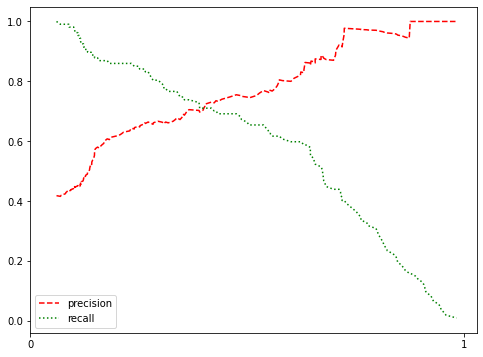

In [160]:
precision_recall_curve_plot(y_test, pred_proba[:,1])

## F1 Score

In [147]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print("오차 행렬")
    print(confusion)
    print("정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1 score: {3:4f},\n |prec-rec|: {4:4f}, prec*rec: {5:4f}, p+c: {6:4f}, */+:{7:4f}".format(
        accuracy, precision, recall, 2*(precision*recall)/(precision+recall), abs(precision-recall), precision*recall,precision+recall,precision*recall/(precision+recall)))

In [148]:
for thr in [0.45,0.43,0.4,0.38]:
    binarizer=Binarizer(threshold = thr)
    print("threshold: ",thr)
    get_clf_eval(y_test,binarizer.fit_transform(pred_proba[:,1].reshape(-1,1)))
    print("")

threshold:  0.45
오차 행렬
[[136  25]
 [ 33  74]]
정확도: 0.7836, 정밀도: 0.7475, 재현율: 0.6916, F1 score: 0.718447,
 |prec-rec|: 0.055886, prec*rec: 0.516945, p+c: 1.439064, */+:0.359223

threshold:  0.43
오차 행렬
[[134  27]
 [ 33  74]]
정확도: 0.7761, 정밀도: 0.7327, 재현율: 0.6916, F1 score: 0.711538,
 |prec-rec|: 0.041084, prec*rec: 0.506709, p+c: 1.424262, */+:0.355769

threshold:  0.4
오차 행렬
[[131  30]
 [ 31  76]]
정확도: 0.7724, 정밀도: 0.7170, 재현율: 0.7103, F1 score: 0.713615,
 |prec-rec|: 0.006701, prec*rec: 0.509258, p+c: 1.427262, */+:0.356808

threshold:  0.38
오차 행렬
[[128  33]
 [ 29  78]]
정확도: 0.7687, 정밀도: 0.7027, 재현율: 0.7290, F1 score: 0.715596,
 |prec-rec|: 0.026269, prec*rec: 0.512251, p+c: 1.431675, */+:0.357798



------
F1 = 2 * (precision * recall) / (precision + recall)<br>
--> precision과 recall이 어느 한쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값을 가진다.

## ROC곡선과 AUC

In [201]:
from sklearn.metrics import roc_curve,roc_auc_score
def draw_ROC(y_test, pred, thres):
    aucc = np.round(roc_auc_score(y_test, pred),4)
    plt.title(f"threshold:{thres},  AUC: {aucc} ",size=15)
    fpr,tpr,thres = roc_curve(y_test, pred)
    plt.plot(fpr,tpr,'k--',color='hotpink')
    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end,0.1),2)) # x축 0.1씩 끊어 보기
    plt.xlabel('FPR(1-TNR)')
    plt.ylabel('TPR')

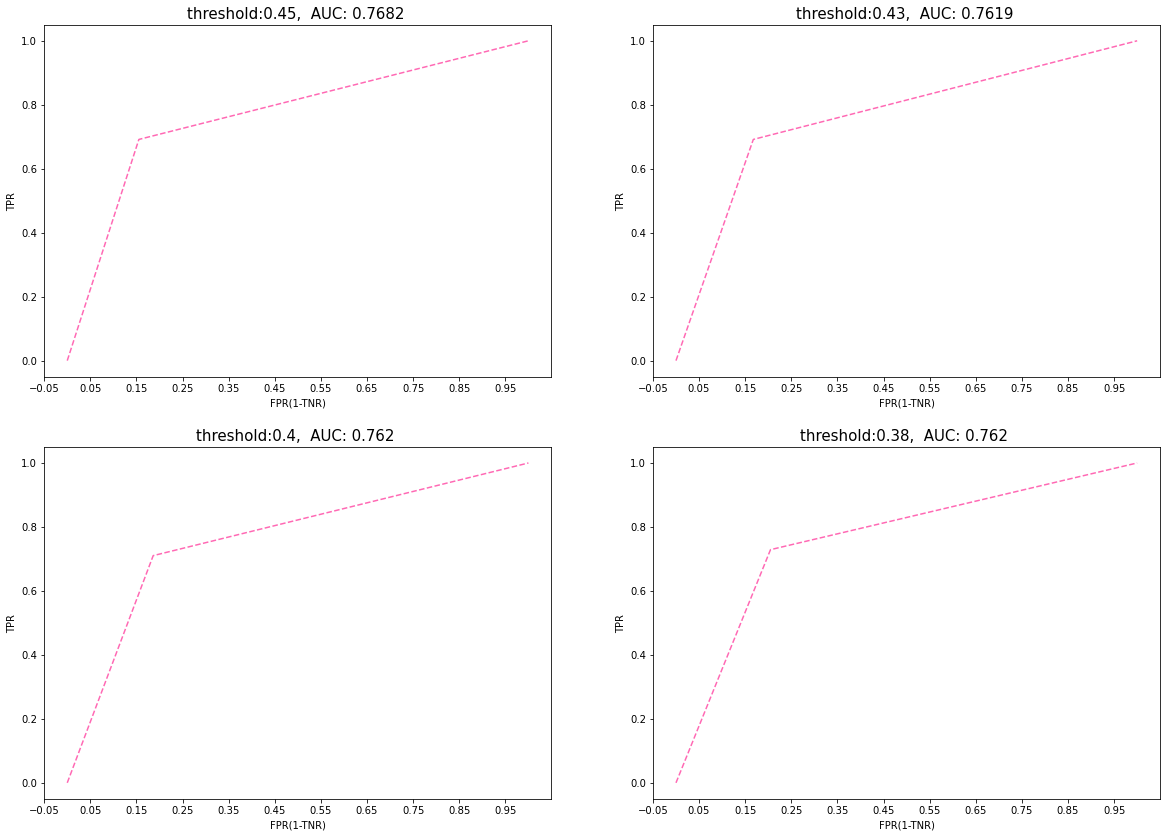

In [202]:
plt.figure(figsize=(20,10))
for e,thr in enumerate([0.45,0.43,0.4,0.38],1):
    plt.subplots_adjust(top=1.2)
    plt.subplot(2,2,e)
    binarizer=Binarizer(threshold = thr)
    draw_ROC(y_test, binarizer.fit_transform(pred_proba[:,1].reshape(-1,1)),thr)

-------
ROC곡선은 FPR과 TPR의 변화 값을 보는 데 이용하며, 
<br>
분류의 성능 지표로 사용되는 것은 ROC곡선 면적에 기반한 AUC(Area Under Curve)값으로 결정한다.